In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import pyplot as plt
from tifffile import imread
import numpy as np
import pickle
import os
import pandas as pd

# root_dir = 'data_ref_hard'
root_dir = 'db'

In [2]:
ct_idx = 0
vol_dim = 4
with open(f'{root_dir}/sample_{ct_idx}/phys_results_{vol_dim}.pickle', 'rb') as file:
    # Deserialize the data from the file and assign it to a variable
    sim_results = pickle.load(file)

#### Porosity check

In [3]:
for i in range(4):
    phys_generate = sim_results[i]['generate']

    print(30*"--")
    print('original',sim_results[i]['original']['porosity'])
    

    for phys_emsemble in phys_generate:
        if not phys_emsemble:
            continue
        print(phys_emsemble['porosity'])

------------------------------------------------------------
original 0.17211228609085083
0.16647589206695557
0.16757798194885254
0.17381954193115234
0.16299188137054443
0.16840410232543945
0.16080039739608765
0.15980565547943115
0.15739285945892334
0.16736358404159546
0.1611032485961914
0.16237866878509521
0.1602998971939087
0.17034977674484253
0.15535372495651245
0.17159217596054077
0.1635097861289978
0.15490174293518066
0.16080242395401
0.1707085371017456
0.15408360958099365
0.156499981880188
0.16903352737426758
0.16370588541030884
0.1667025089263916
0.15680640935897827
0.16114944219589233
0.1642690896987915
0.17166370153427124
0.16903525590896606
0.16045504808425903
------------------------------------------------------------
original 0.13570594787597656
0.12684381008148193
0.11778318881988525
0.12241494655609131
0.11576402187347412
0.12260067462921143
0.12061583995819092
0.11770617961883545
0.12303227186203003
0.12041270732879639
0.12525665760040283
0.12363845109939575
0.118315041

#### Perm check

In [4]:
k_gen, k_real, k_compare = [], [], []

for i in range(4):
    phys_generate = sim_results[i]['generate']
    phys_real = sim_results[i]['original']
    for phys_emsemble in phys_generate:
        if not phys_emsemble:
            continue
        k_gen.append(phys_emsemble['kabs'][0])
        k_real.append(phys_real['kabs'][0])


# comparison

compare_results = sim_results['compare']

for compare_phys in compare_results:
    if not compare_phys:
        continue
    k_compare.append(compare_phys['kabs'][0])
    

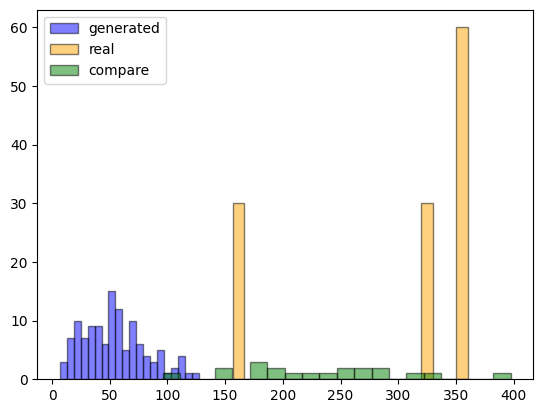

In [5]:
# plot histogram of kabs 

f = plt.figure()
plt.hist(k_gen, bins=20, alpha=0.5,edgecolor = 'black', facecolor='blue', label='generated')
plt.hist(k_real, bins=20, alpha=0.5,edgecolor = 'black', facecolor='orange', label='real')
plt.hist(k_compare, bins=20, alpha=0.5,edgecolor = 'black', facecolor='green', label='compare')

plt.legend()


In [6]:
def plot_figure_air(kr_results_real, kr_results_pred, sim_results):
    f = plt.figure()
    # Using 'yo-' for yellow dots with a line, making the line thicker for visibility
    plt.plot(kr_results_real['snw'], kr_results_real['kr_air'], 'yo-', linewidth=3, label='real')

    for ensemble in kr_results_pred:
        if not ensemble:
            continue
        # Using 'r*-' for red stars with a line, specifying a smaller line width
        plt.plot(ensemble['snw'], ensemble['kr_air'], 'r*:', linewidth=2, label='pred')

    # Plot comparison
    compare_phys = sim_results['compare']
    for compare in compare_phys:
        if not compare:
            continue
        # Using 'g.' for gray dots, no connecting line, and specifying marker size for smaller appearance
        plt.plot(compare['snw'], compare['kr_air'], 'g.', color='gray', markersize=5, label='compare')

    plt.show()



def plot_figure_water(kr_results_real, kr_results_pred, sim_results):
    f = plt.figure()
    # Using 'yo-' for yellow dots with a line, making the line thicker for visibility
    plt.plot(kr_results_real['snw'], kr_results_real['kr_water'], 'yo-', linewidth=3, label='real')

    for ensemble in kr_results_pred:
        if not ensemble:
            continue
        # Using 'r*-' for red stars with a line, specifying a smaller line width
        plt.plot(ensemble['snw'], ensemble['kr_water'], 'r*:', linewidth=2, label='pred')

    # Plot comparison
    compare_phys = sim_results['compare']
    for compare in compare_phys:
        if not compare:
            continue
        # Using 'g.' for gray dots, no connecting line, and specifying marker size for smaller appearance
        plt.plot(compare['snw'], compare['kr_water'], 'g.', color='gray', markersize=5, label='compare')

    plt.show()

#### Rekatuve perm checkout

In [26]:
ct_idx = 2
vol_dim = 4
with open(f'{root_dir}/sample_{ct_idx}/phys_results_{vol_dim}.pickle', 'rb') as file:
    # Deserialize the data from the file and assign it to a variable
    sim_results = pickle.load(file)



In [31]:
len(sim_results[0]['generate'])

30

/tmp/ipykernel_478387/1139514112.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g." (-> color='g'). The keyword argument will take precedence.
  plt.plot(compare['snw'], compare['kr_air'], 'g.', color='gray', markersize=5, label='compare')


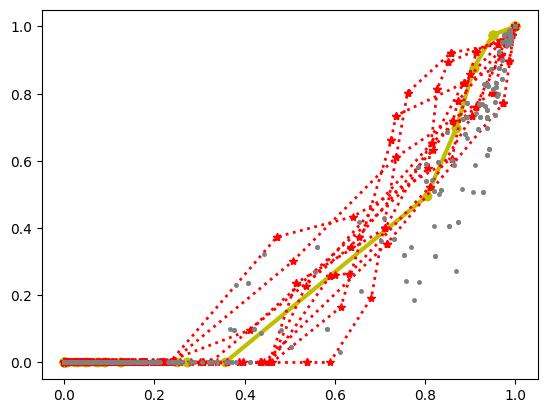

/tmp/ipykernel_478387/1139514112.py:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g." (-> color='g'). The keyword argument will take precedence.
  plt.plot(compare['snw'], compare['kr_water'], 'g.', color='gray', markersize=5, label='compare')


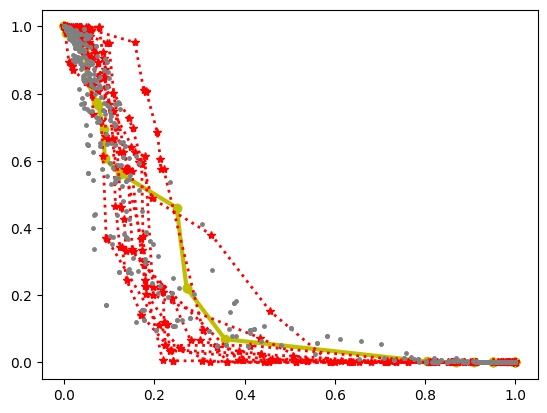

In [28]:
# plot original kr
sample_idx = 0
kr_results_real = sim_results[sample_idx]['original']
kr_results_pred = sim_results[sample_idx]['generate'][:10]

plot_figure_air(kr_results_real, kr_results_pred, sim_results)
plot_figure_water(kr_results_real, kr_results_pred, sim_results)

In [9]:

# sample_idx = 0
# realization_idx = 1
# kr_results_pred = sim_results[sample_idx]['generate'][:]
# compare = kr_results_pred[realization_idx]

# kr_db = pd.DataFrame(
#     {
#     'snw':compare['snw'],
#     'sw': compare['sw'],
#     'kr_air':compare['kr_air'],
#     'kr_water':compare['kr_water']
#                       }
#                       )


# def get_irr_sw(db):
#     db = db[db['kr_water']<1e-05]
#     return db['sw'].max()

# def get_res_sw(db):
#     db = db[db['kr_air']<1e-07]
#     return db['snw'].max()

# sw_irr = get_irr_sw(kr_db)
# snw_res = get_res_sw(kr_db)

# db = kr_db[( (kr_db['sw']>=sw_irr) & (kr_db['snw']>=snw_res) )]

# plt.plot(db['sw'], db['kr_air'], 'g.-', color='gray', markersize=5, label='compare')
# plt.plot(db['sw'], db['kr_water'], 'g.-', color='gray', markersize=5, label='compare')
# plt.xlim([0,1])
# plt.ylim([0,1])

/tmp/ipykernel_478387/1139514112.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g." (-> color='g'). The keyword argument will take precedence.
  plt.plot(compare['snw'], compare['kr_air'], 'g.', color='gray', markersize=5, label='compare')


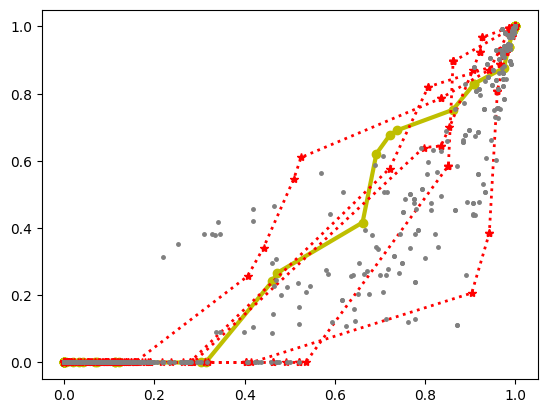

/tmp/ipykernel_478387/1139514112.py:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g." (-> color='g'). The keyword argument will take precedence.
  plt.plot(compare['snw'], compare['kr_water'], 'g.', color='gray', markersize=5, label='compare')


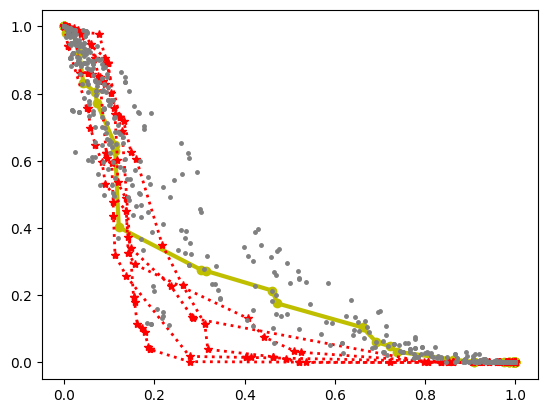

In [16]:


# f = plt.figure()
# # Using 'yo-' for yellow dots with a line, making the line thicker for visibility
# plt.plot(kr_results_real['sw'], kr_results_real['kr_water'], 'yo-', linewidth=3, label='real')

# for ensemble in kr_results_pred:
#     # Using 'r*-' for red stars with a line, specifying a smaller line width
#     plt.plot(ensemble['sw'], ensemble['kr_water'], 'r*:', linewidth=2, label='pred')

# # Plot comparison
# compare_phys = sim_results['compare']
# for compare in compare_phys:
#     # Using 'g.' for gray dots, no connecting line, and specifying marker size for smaller appearance
#     plt.plot(compare['sw'], compare['kr_water'], 'g.', color='gray', markersize=5, label='compare')

# plt.show()




/tmp/ipykernel_478387/1139514112.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g." (-> color='g'). The keyword argument will take precedence.
  plt.plot(compare['snw'], compare['kr_air'], 'g.', color='gray', markersize=5, label='compare')


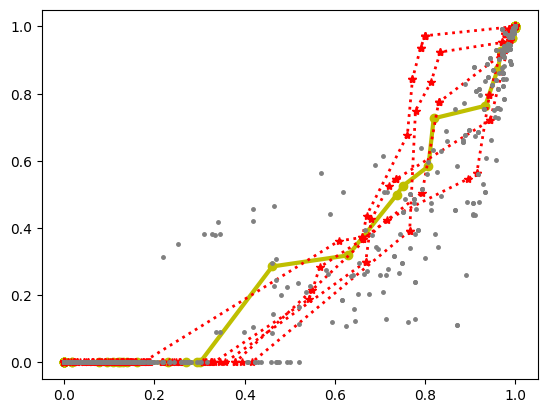

/tmp/ipykernel_478387/1139514112.py:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g." (-> color='g'). The keyword argument will take precedence.
  plt.plot(compare['snw'], compare['kr_water'], 'g.', color='gray', markersize=5, label='compare')


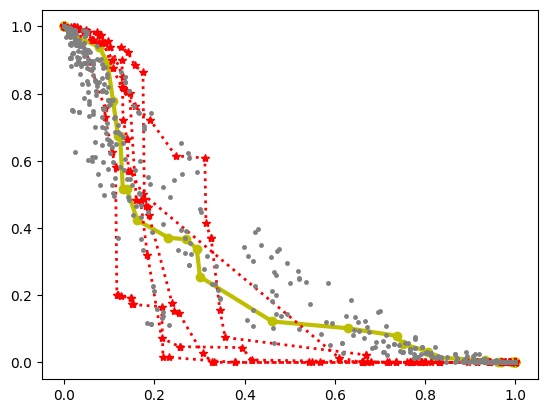

In [14]:
sample_idx = 3
kr_results_real = sim_results[sample_idx]['original']
kr_results_pred = sim_results[sample_idx]['generate'][:5]



plot_figure_air(kr_results_real, kr_results_pred, sim_results)
plot_figure_water(kr_results_real, kr_results_pred, sim_results)

/tmp/ipykernel_1440818/1139514112.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g." (-> color='g'). The keyword argument will take precedence.
  plt.plot(compare['snw'], compare['kr_air'], 'g.', color='gray', markersize=5, label='compare')


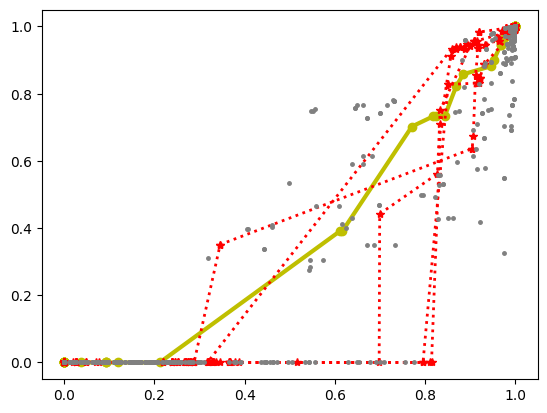

/tmp/ipykernel_1440818/1139514112.py:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g." (-> color='g'). The keyword argument will take precedence.
  plt.plot(compare['snw'], compare['kr_water'], 'g.', color='gray', markersize=5, label='compare')


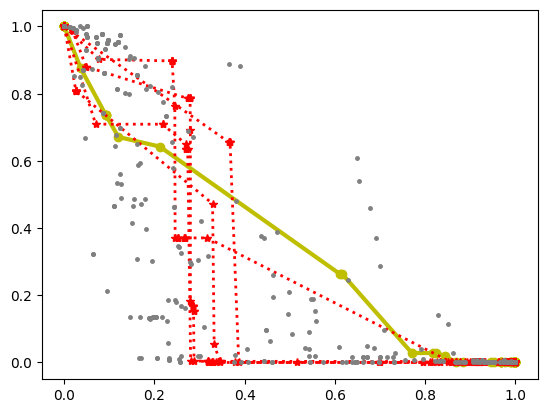

In [10]:
sample_idx = 2
kr_results_real = sim_results[sample_idx]['original']
kr_results_pred = sim_results[sample_idx]['generate'][:5]



plot_figure_air(kr_results_real, kr_results_pred, sim_results)
plot_figure_water(kr_results_real, kr_results_pred, sim_results)

/tmp/ipykernel_1440818/1139514112.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g." (-> color='g'). The keyword argument will take precedence.
  plt.plot(compare['snw'], compare['kr_air'], 'g.', color='gray', markersize=5, label='compare')


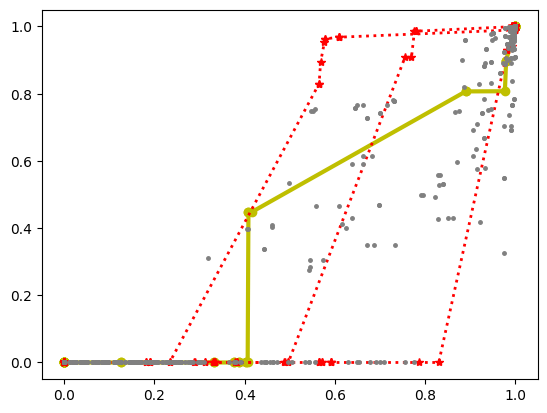

/tmp/ipykernel_1440818/1139514112.py:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g." (-> color='g'). The keyword argument will take precedence.
  plt.plot(compare['snw'], compare['kr_water'], 'g.', color='gray', markersize=5, label='compare')


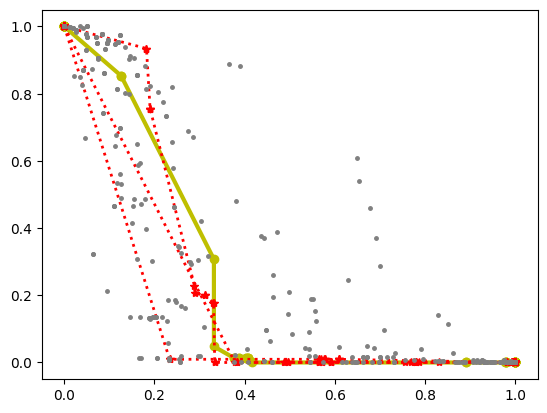

In [11]:
sample_idx = 3
kr_results_real = sim_results[sample_idx]['original']
kr_results_pred = sim_results[sample_idx]['generate'][:5]



plot_figure_air(kr_results_real, kr_results_pred, sim_results)
plot_figure_water(kr_results_real, kr_results_pred, sim_results)

#### Set up physical boundary

/tmp/ipykernel_1440818/2840934119.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g." (-> color='g'). The keyword argument will take precedence.
  plt.plot(compare['snw'], compare['kr_air'], 'g.', color='gray', markersize=5, label='compare')


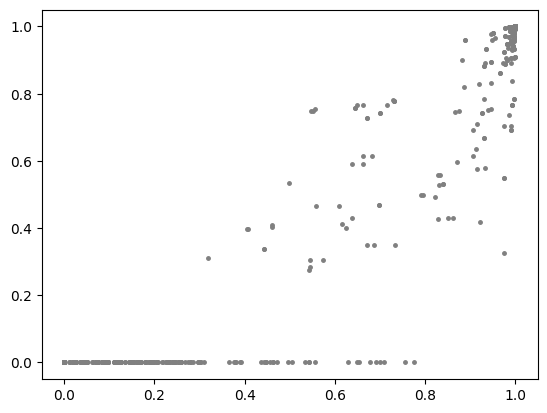

In [12]:
compare_phys = sim_results['compare']
for compare in compare_phys:
 
    # Using 'g.' for gray dots, no connecting line, and specifying marker size for smaller appearance
    plt.plot(compare['snw'], compare['kr_air'], 'g.', color='gray', markersize=5, label='compare')

/tmp/ipykernel_824231/1155028651.py:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g." (-> color='g'). The keyword argument will take precedence.
  plt.plot(compare['snw'], compare['kr_water'], 'g.', color='gray', markersize=5, label='compare')


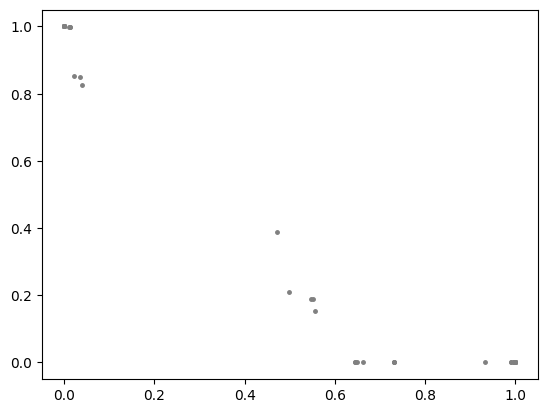

In [54]:
plt.plot(compare['snw'], compare['kr_water'], 'g.', color='gray', markersize=5, label='compare')


In [17]:
import pandas as pd

kr_db = pd.DataFrame(
    {
    'snw':compare['snw'],
    'sw': compare['sw'],
    'kr_air':compare['kr_air'],
    'kr_water':compare['kr_water']
                      }
                      )

/tmp/ipykernel_1440818/126533749.py:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g." (-> color='g'). The keyword argument will take precedence.
  plt.plot(kr_db['sw'], kr_db['kr_air'], 'g.', color='gray', markersize=5, label='compare')
/tmp/ipykernel_1440818/126533749.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g." (-> color='g'). The keyword argument will take precedence.
  plt.plot(kr_db['sw'], kr_db['kr_water'], 'g.', color='gray', markersize=5, label='compare')


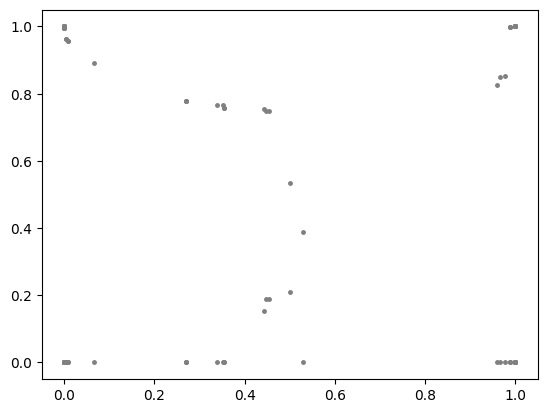

In [22]:
plt.plot(kr_db['sw'], kr_db['kr_air'], 'g.', color='gray', markersize=5, label='compare')
plt.plot(kr_db['sw'], kr_db['kr_water'], 'g.', color='gray', markersize=5, label='compare')

In [45]:
# write a function to get irreducible water saturation

def get_irr_sw(db):
    db = db[db['kr_water']<1e-05]
    return db['sw'].max()

def get_res_sw(db):
    db = db[db['kr_air']<1e-07]
    return db['snw'].max()

sw_irr = get_irr_sw(kr_db)
snw_res = get_res_sw(kr_db)

db = kr_db[( (kr_db['sw']>=sw_irr) & (kr_db['snw']>=snw_res) )]

/tmp/ipykernel_1440818/1384590886.py:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g.-" (-> color='g'). The keyword argument will take precedence.
  plt.plot(db['sw'], db['kr_air'], 'g.-', color='gray', markersize=5, label='compare')
/tmp/ipykernel_1440818/1384590886.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g.-" (-> color='g'). The keyword argument will take precedence.
  plt.plot(db['sw'], db['kr_water'], 'g.-', color='gray', markersize=5, label='compare')


(0.0, 1.0)

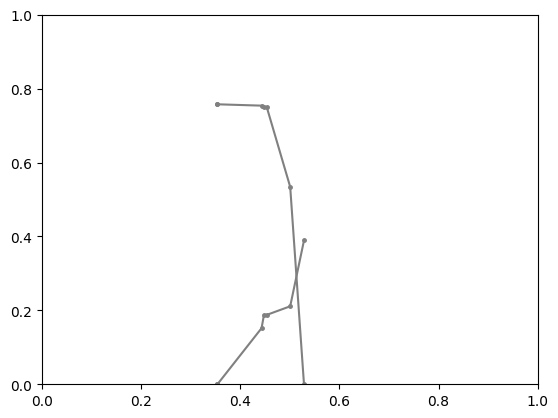

In [47]:
plt.plot(db['sw'], db['kr_air'], 'g.-', color='gray', markersize=5, label='compare')
plt.plot(db['sw'], db['kr_water'], 'g.-', color='gray', markersize=5, label='compare')
plt.xlim([0,1])
plt.ylim([0,1])